<a href="https://colab.research.google.com/github/molonepa/pneumonia_classifier/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import cv2
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report
from pandas.core.common import flatten
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import glob
import os
import random
import time

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

/home/nurenda/.virtualenvs/pneumonia/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


Set up datasets

In [2]:
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for image, ax in zip( images, axes):
        ax.imshow(image.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
TRAIN_DIR = 'data/train'
VAL_DIR = 'data/val'
TEST_DIR = 'data/test'

classes = []
train = []
val = []
test = []

for data_path in glob.glob(os.path.join(TRAIN_DIR, '*')):
    cls = data_path.split('/')[-1]
    imgs = glob.glob(os.path.join(data_path, '*'))
    classes.append(cls)
    train.append(imgs)

train = list(flatten(train))
random.shuffle(train)
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

for data_path in glob.glob(os.path.join(VAL_DIR, '*')):
    imgs = glob.glob(os.path.join(data_path, '*'))
    val.append(imgs)

val = list(flatten(val))
random.shuffle(val)

for data_path in glob.glob(os.path.join(TEST_DIR, '*')):
    imgs = glob.glob(os.path.join(data_path, '*'))
    test.append(imgs)

test = list(flatten(test))

print('class example: ', classes[0])
print('train example: ', train[0])
print('val example: ', val[0])
print('test example: ', test[0])

class example:  PNEUMONIA
train example:  data/train/PNEUMONIA/person1354_bacteria_3448.jpeg
val example:  data/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
test example:  data/test/PNEUMONIA/person1608_virus_2786.jpeg


In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

train_dataset = ImageDataset(train, image_transforms)
val_dataset = ImageDataset(val, image_transforms)
test_dataset = ImageDataset(test, image_transforms)

Model definition

In [5]:
class BaselineModel(nn.Module):
    """
    Baseline model built on LeNet architecture.
    """
    def __init__(self, num_classes):
        super().__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 4, 5)
        self.conv2 = nn.Conv2d(4, 8, 5)

        self.fc1 = nn.Linear(8 * 125 * 125, 125)
        self.fc2 = nn.Linear(125, num_classes)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # first Conv => ReLU => Pool block
        x = self.pool(self.relu(self.conv1(x)))
        # second Conv => ReLU => Pool block
        x = self.pool(self.relu(self.conv2(x)))

        # flatten
        x = torch.flatten(x, 1)

        # first FC
        x = self.relu(self.fc1(x))
        # second FC
        x = self.fc2(x)

        # class predictions
        output = self.logsoftmax(x)

        return output

model = BaselineModel(len(classes)).to(device)
summary(model, input_size=(3, 512, 512), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 508, 508]             304
              ReLU-2          [-1, 4, 508, 508]               0
         MaxPool2d-3          [-1, 4, 254, 254]               0
            Conv2d-4          [-1, 8, 250, 250]             808
              ReLU-5          [-1, 8, 250, 250]               0
         MaxPool2d-6          [-1, 8, 125, 125]               0
            Linear-7                  [-1, 125]      15,625,125
              ReLU-8                  [-1, 125]               0
            Linear-9                    [-1, 2]             252
       LogSoftmax-10                    [-1, 2]               0
Total params: 15,626,489
Trainable params: 15,626,489
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 26.30
Params size (MB): 59.61
Est

Train

In [6]:
INITIAL_LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 64

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_steps = len(train_loader) // BATCH_SIZE
val_steps = len(val_loader) // BATCH_SIZE

In [7]:
start = time.time()

for e in range(EPOCHS):
    print('Epoch {}/{}'.format(e+1, EPOCHS))
    model.train()

    total_train_loss = 0
    total_val_loss = 0

    train_correct = 0
    val_correct = 0

    print('Train:')
    for (x, y) in tqdm(train_loader):
        (x, y) = (x.to(device), y.to(device))

        pred = model(x)
        loss = loss_func(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    print('Val:')
    with torch.no_grad():
        model.eval()

        for (x, y) in tqdm(val_loader):
            (x, y) = (x.to(device), y.to(device))

            pred = model(x)

            total_val_loss += loss_func(pred, y)
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps

    train_correct = train_correct / len(train_loader.dataset)
    val_correct = val_correct / len(val_loader.dataset)

    history["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    history["train_acc"].append(train_correct)
    history["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    history["val_acc"].append(val_correct)

    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avg_val_loss, val_correct))

    torch.save(model, "models/model_epoch_{}.pth".format(e))

end = time.time()

print('Total training time: {:.2f}s'.format(end - start))

Epoch 0/10
Train:


100%|██████████| 82/82 [01:50<00:00,  1.35s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Train loss: 32.794727, Train accuracy: 0.8257
Val loss: inf, Val accuracy: 0.8125

Epoch 1/10
Train:


100%|██████████| 82/82 [01:49<00:00,  1.33s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Train loss: 14.386801, Train accuracy: 0.9310
Val loss: inf, Val accuracy: 0.8750

Epoch 2/10
Train:


100%|██████████| 82/82 [01:51<00:00,  1.36s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Train loss: 9.143725, Train accuracy: 0.9559
Val loss: inf, Val accuracy: 1.0000

Epoch 3/10
Train:


100%|██████████| 82/82 [01:50<00:00,  1.35s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Train loss: 5.642854, Train accuracy: 0.9737
Val loss: inf, Val accuracy: 1.0000

Epoch 4/10
Train:


100%|██████████| 82/82 [01:51<00:00,  1.36s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Train loss: 4.806271, Train accuracy: 0.9812
Val loss: inf, Val accuracy: 0.9375

Epoch 5/10
Train:


100%|██████████| 82/82 [01:51<00:00,  1.36s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Train loss: 7.494597, Train accuracy: 0.9674
Val loss: inf, Val accuracy: 0.9375

Epoch 6/10
Train:


100%|██████████| 82/82 [01:51<00:00,  1.36s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Train loss: 11.339462, Train accuracy: 0.9429
Val loss: inf, Val accuracy: 0.8125

Epoch 7/10
Train:


100%|██████████| 82/82 [01:51<00:00,  1.36s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Train loss: 3.943542, Train accuracy: 0.9826
Val loss: inf, Val accuracy: 1.0000

Epoch 8/10
Train:


100%|██████████| 82/82 [01:53<00:00,  1.39s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Train loss: 2.377710, Train accuracy: 0.9895
Val loss: inf, Val accuracy: 1.0000

Epoch 9/10
Train:


100%|██████████| 82/82 [01:55<00:00,  1.41s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

Train loss: 1.853428, Train accuracy: 0.9921
Val loss: inf, Val accuracy: 1.0000

Total training time: 1119.97s


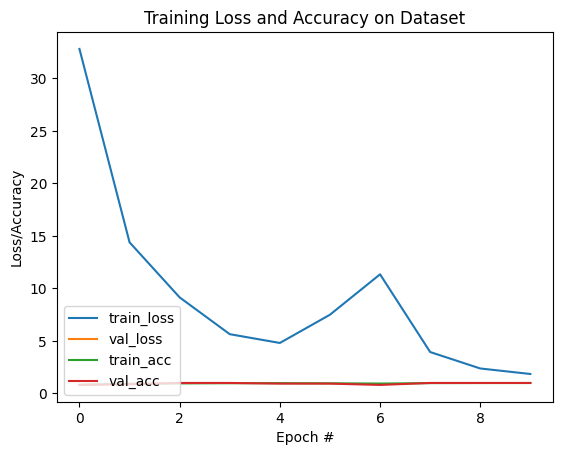

In [8]:
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("output/training.png")

Testing

In [9]:
with torch.no_grad():
    model.eval()

    predictions = []
    targets = []

    print("Test: ")
    for (x, y) in tqdm(test_loader):
        x = x.to(device)

        pred = model(x)
        predictions.extend(pred.argmax(axis=1).cpu().numpy())
        targets.extend(y)

print(classification_report(targets, np.array(predictions), target_names=classes))

Test: 


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

              precision    recall  f1-score   support

   PNEUMONIA       0.69      1.00      0.82       390
      NORMAL       1.00      0.26      0.41       234

    accuracy                           0.72       624
   macro avg       0.85      0.63      0.62       624
weighted avg       0.81      0.72      0.67       624

